#2. 地理空間の分布パターン

## 2.1 空間隣接行列

###2.1.1 事前準備

In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/mount')

Mounted at /content/mount


In [2]:
# ワーキングディレクトリの設定
%cd '/content/mount/MyDrive/SDS'

/content/mount/MyDrive/SDS


In [3]:
# 必要なライブラリのインストール
!pip install -q geopandas
!pip install -q pysal
!pip install -q japanize_matplotlib  # 日本語文字化け解消用モジュール

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# 必要なライブラリのインポート
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語文字化け解消用モジュール
import scipy.stats as st  # 正規分布の累積密度関数を利用する

from pysal.lib import weights  # geopandasデータフレームから隣接関係を作成
from pysal.explore import esda  # Moran'Iを求めるモジュール
from splot.esda import plot_moran  # splotはpysalとの依存関係でインストールされる
from splot import esda as esdaplot  # Moran'Iの図示用モジュール

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### 2.1.2 データのインポートとgeopandasデータフレームの作成

In [5]:
# ファイルパスの設定
DISTRICT_PATH = "./Chapter2/data/N03-20220101_27_GML/N03-22_27_220101.shp"
LAND_PATH = "./Chapter2/data/L01-23_27_GML/L01-23_27.shp"

In [6]:
# shpファイル読込
# ポリゴン（行政区域データ）
gdf_district = gpd.read_file(DISTRICT_PATH)  # Shapefile読込
# ポイント（地価公示データ）
gdf_land = gpd.read_file(LAND_PATH)  # Shapefile読込

In [7]:
# 変換後の空間座標系指定
# JGD2000緯度経度(EPSG4612) → JGD2011緯度経度(EPSG6668)
dst_proj = 6668 # 変換後の座標系のEPSGコードを指定
# 地価公示データのgeopandasデータフレームについて空間座標系を一括変換
# to_crs()関数を用いて、引数で空間座標系のEPSGコードを指定
gdf_land = gdf_land.to_crs(epsg=dst_proj)

In [8]:
# gdf_districtの作成
# 0番目のインデックス(行)の削除
gdf_district = gdf_district.drop(index = 0)
# 必要な列のみで再構成
gdf_district = gdf_district[['N03_003', 'N03_004', 'N03_007', 'geometry']]
# 列名の付け直し
gdf_district.columns = ['city1', 'city2', 'd_code', 'geometry']

In [9]:
# gdf_landの作成
# 必要な列のみで再構成
gdf_land = gdf_land[['L01_024', 'L01_022', 'L01_006', 'geometry']]
# 列名の付け直し
gdf_land.columns = ['address', 'd_code', 'price', 'geometry']

In [10]:
# address列にある余計な空白文字を消去
gdf_land['address'] = gdf_land['address'].str.replace('　', '')

In [11]:
# np.log()で対数変換し、geopandasデータフレームに新たな列(log_price)として追加
gdf_land['log_price'] = np.log(gdf_land['price'])

In [12]:
# 地域コードをもとにグループを作る
grouped = gdf_land.groupby('d_code')

In [13]:
# グループ内の列('log_price')の平均を求めて新しいpandasデータフレームを作成
price_mean_df = grouped['log_price'].mean()

In [14]:
# 'log_price'列を行政区域データフレームに結合して新しいデータフレームを作成
gdf_osaka = gdf_district.merge(price_mean_df, on = 'd_code')

In [15]:
# gdf_osakaデータフレームの確認
gdf_osaka.head()

,city1,city2,d_code,geometry,log_price
0,大阪市,都島区,27102,"POLYGON ((135.51481 34.72057, 135.51489 34.720...",12.769969
1,大阪市,福島区,27103,"POLYGON ((135.48403 34.69969, 135.48404 34.699...",13.214822
2,大阪市,此花区,27104,"POLYGON ((135.35833 34.62786, 135.35860 34.627...",12.191524
3,大阪市,此花区,27104,"POLYGON ((135.39884 34.65724, 135.39877 34.657...",12.191524
4,大阪市,此花区,27104,"POLYGON ((135.39893 34.65737, 135.39892 34.657...",12.191524


In [16]:
# dissolveでcity2が共通の地域ごとにまとめる
gdf_osaka = gdf_osaka.dissolve(by=["d_code"], as_index=False)
gdf_osaka.head()

,d_code,geometry,city1,city2,log_price
0,27102,"POLYGON ((135.51481 34.72057, 135.51489 34.720...",大阪市,都島区,12.769969
1,27103,"POLYGON ((135.48403 34.69969, 135.48404 34.699...",大阪市,福島区,13.214822
2,27104,"MULTIPOLYGON (((135.36506 34.63250, 135.35885 ...",大阪市,此花区,12.191524
3,27106,"POLYGON ((135.49759 34.68508, 135.49765 34.684...",大阪市,西区,13.746399
4,27107,"MULTIPOLYGON (((135.43009 34.64977, 135.43010 ...",大阪市,港区,12.410058


### 2.1.3 地域の隣接関係を可視化

In [17]:
# 行政区域のポリゴンの中心座標を求めて
# データフレームの列(centers)に加える
gdf_osaka['centers'] = gdf_osaka['geometry'].centroid
gdf_osaka.head()

<ipython-input-17-d1181ed97648>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_osaka['centers'] = gdf_osaka['geometry'].centroid


,d_code,geometry,city1,city2,log_price,centers
0,27102,"POLYGON ((135.51481 34.72057, 135.51489 34.720...",大阪市,都島区,12.769969,POINT (135.52721 34.71193)
1,27103,"POLYGON ((135.48403 34.69969, 135.48404 34.699...",大阪市,福島区,13.214822,POINT (135.47534 34.69390)
2,27104,"MULTIPOLYGON (((135.36506 34.63250, 135.35885 ...",大阪市,此花区,12.191524,POINT (135.42012 34.66800)
3,27106,"POLYGON ((135.49759 34.68508, 135.49765 34.684...",大阪市,西区,13.746399,POINT (135.48375 34.67776)
4,27107,"MULTIPOLYGON (((135.43009 34.64977, 135.43010 ...",大阪市,港区,12.410058,POINT (135.45084 34.66032)


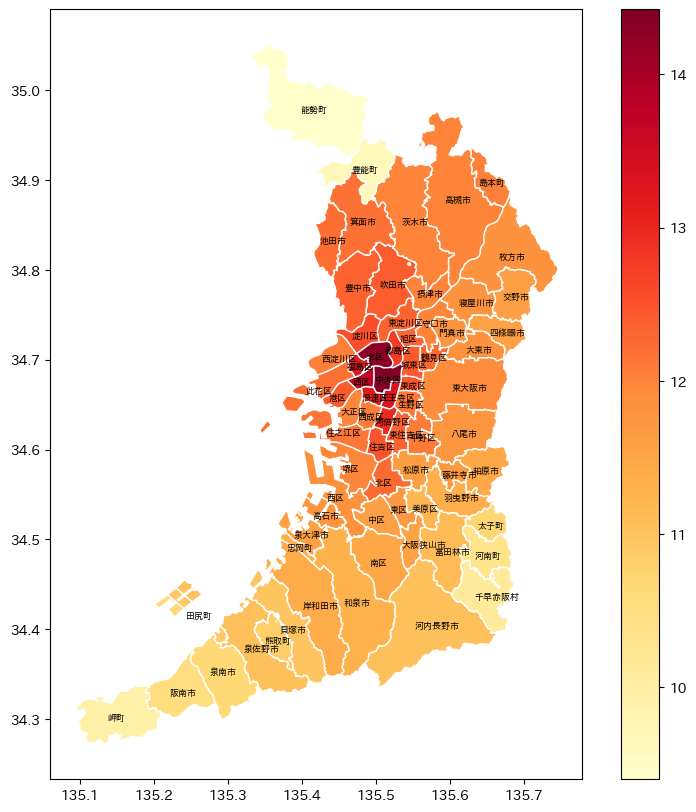

In [18]:
# figureとaxを生成
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# 行政区域地図の上に地価分布図を重ね合わせる
gdf_osaka.plot(ax = ax,
                    column = 'log_price',  # 色分け対象の列(対数値の地価)
                    cmap = 'YlOrRd',  # 色分けのカラーマップ
                    legend = True, # 凡例(カラーバー)の表示
                    edgecolor='white'  # 区域の境界を白色に指定
                    )
# 各行政区域のポリゴンにデータラベルを付与する
for x, y, label in zip(gdf_osaka.centers.x, gdf_osaka.centers.y, gdf_osaka.city2):
    ax.annotate(label, xy=(x-0.015, y-0.005), size = 6.5)  # ラベル位置の微調整が必要
# 地図の保存
fig.savefig("./Chapter2/figures/figure2_1.png")
# 地図の表示
plt.show()

### 2.1.4 空間隣接行列の作成

In [19]:
# geopandasデータフレームから隣接関係(contiguity)をルーク型で作成
wr = weights.Rook.from_dataframe(gdf_osaka)

<ipython-input-19-94e8478472b6>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.Rook.from_dataframe(gdf_osaka)


In [20]:
# 隣接関係のリストを作成(結果は辞書形式で返る)
wr.neighbors

{0: [22, 23, 9, 12, 13],
 1: [2, 3, 18, 22, 8],
 2: [8, 1, 3, 4],
 3: [1, 2, 4, 5, 22, 7, 23],
 4: [2, 3, 5],
 5: [17, 3, 4, 20, 7],
 6: [17, 7, 23, 10, 11, 14],
 7: [17, 3, 5, 6, 23],
 8: [1, 2, 18],
 9: [0, 34, 18, 53, 38, 22, 12],
 10: [6, 23, 56, 11, 13],
 11: [16, 21, 6, 56, 10, 14],
 12: [0, 19, 38, 9, 13],
 13: [0, 19, 23, 56, 10, 12],
 14: [16, 17, 6, 11, 15],
 15: [16, 17, 20, 14, 24, 29, 46],
 16: [21, 14, 11, 46, 15],
 17: [20, 5, 6, 7, 14, 15],
 18: [32, 1, 34, 22, 8, 9],
 19: [52, 38, 56, 12, 13, 47],
 20: [24, 17, 5, 15],
 21: [16, 56, 41, 11, 46],
 22: [0, 1, 18, 3, 23, 9],
 23: [0, 3, 6, 7, 22, 10, 13],
 24: [27, 20, 29, 15],
 25: [26, 27, 28, 29, 60],
 26: [25, 60, 29, 30],
 27: [48, 54, 24, 25, 28, 29],
 28: [48, 25, 27, 60, 45],
 29: [30, 24, 25, 26, 27, 46, 15],
 30: [51, 26, 43, 60, 29, 46],
 31: [48, 65, 37],
 32: [33, 18, 34, 49],
 33: [32, 49],
 34: [32, 49, 18, 53, 40, 9],
 35: [48, 65, 54],
 36: [53, 39, 40, 44, 62],
 37: [66, 42, 31],
 38: [19, 52, 53, 9, 12,

In [21]:
# 隣接行列(adjacent matrix)の作成
adj_mat = wr.full()[0].astype(int)
print(adj_mat)
print(adj_mat.shape)  # 隣接行列の形状

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
(72, 72)


##2.2 空間重み行列

In [22]:
# 行和を作成する
sum_row = adj_mat.sum(axis=1)
sum_row

array([5, 5, 4, 7, 3, 5, 6, 5, 3, 7, 5, 6, 5, 6, 5, 7, 5, 6, 6, 6, 4, 5,
       6, 7, 4, 5, 4, 6, 5, 7, 6, 3, 4, 2, 6, 3, 5, 3, 6, 4, 5, 5, 4, 7,
       8, 5, 8, 5, 7, 5, 3, 6, 4, 6, 3, 4, 7, 3, 3, 3, 6, 2, 2, 3, 1, 3,
       2, 2, 1, 3, 3, 3])

In [23]:
# 空間重み行列(Spatial Weighted Matrix)の作成：各行和が1になるように基準化
swm = adj_mat / sum_row[:,None]
# 行和が0の場合割り算ができずNaNとなるので、それらを0で埋める(念のため)
np.nan_to_num(swm, 0)
swm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ]])

##2.3 空間的自己相関(1)～Global Moran's I

### 2.3.1 Global Moran's Iとは

省略

###2.3.2 Global Moran's Iを求める

In [24]:
# geopandasデータフレームの列をnp.ndarray型に変換
x = gdf_osaka['log_price'].values

In [25]:
# Global Moran's Iを求める(引数はデータxと空間重み行列swm)
def culc_GMI(x,swm):
  x_dev = x - np.mean(x)  # 偏差のベクトルを求める
  N = len(x)  # データ数はN
  GMI = N / np.sum(swm) * (x_dev.T @ swm @ x_dev) / (x_dev.T @ x_dev)
  return GMI

In [26]:
GMI = culc_GMI(x, swm)
GMI

0.7448212732463018

###2.3.3 Global Moran's Iの検定

In [27]:
# Global Moran's Iの経験的p値を求める
def culc_p_val_g(x, GMI):
  max_iter = 999  # イタレーションの最大値
  rng = np.random.default_rng()  # 乱数発生のためのジェネレータオブジェクトの生成
  GMI_sim = []
  for i in range(max_iter):
    tmp_x = rng.permutation(x)  # 与えられた配列をランダムに並び替える
    tmp_GMI = culc_GMI(tmp_x, swm)  # ランダムデータのGMIを求める
    GMI_sim.append(tmp_GMI)

  above = np.array(GMI_sim) >= GMI  # GMI_simの値がGMIを超えているか(True or False)
  larger = np.sum(above)  # GMIを超えているGMI_simの値の個数を求める
  p_sim = (larger + 1) / (max_iter + 1)  # 発生しがたい事象の確率(p値)を求める

  mean_sim = np.mean(GMI_sim)  # シミュレーションデータの平均
  var_sim = np.var(GMI_sim, ddof=1)  # シミュレーションデータの分散
  z_sim = (GMI - mean_sim) / np.sqrt(var_sim)  # シミュレーションデータのz値

  p_z_sim = 1 - st.norm.cdf(z_sim)  # z_simのp値を求める

  return {'Is': GMI_sim, 'p_sim': p_sim, 'EI_sim': mean_sim, 'VI_sim': var_sim, 'z_sim': z_sim, 'p_z_sim': p_z_sim}

In [28]:
sim_res = culc_p_val_g(x, GMI)

In [29]:
print('p_sim : ', sim_res['p_sim'])
print('z_sim : ', sim_res['z_sim'])
print('p_z_sim : ', sim_res['p_z_sim'])

p_sim :  0.001
z_sim :  9.44276833908215
p_z_sim :  0.0


###2.3.4 Global Moran's Iの検定結果を図示する

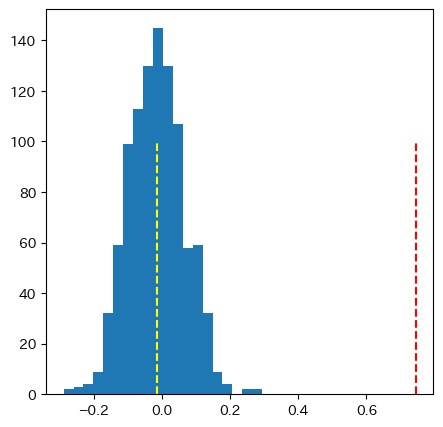

In [30]:
# figureとaxを生成
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax = plt.hist(sim_res['Is'], bins=20)
ax = plt.vlines(sim_res['EI_sim'], 0, 100, 'yellow', 'dashed')  # シミュレーション平均
ax = plt.vlines(GMI, 0, 100, 'red', 'dashed')  # GMI
# 図の保存
fig.savefig("./Chapter2/figures/figure2_2.png")
# 図の表示
plt.show()

In [31]:
# 標準化されたxの偏差
z = (x - np.mean(x)) / np.std(x)
# 空間ラグ(spatial lag)
sl = swm @ z

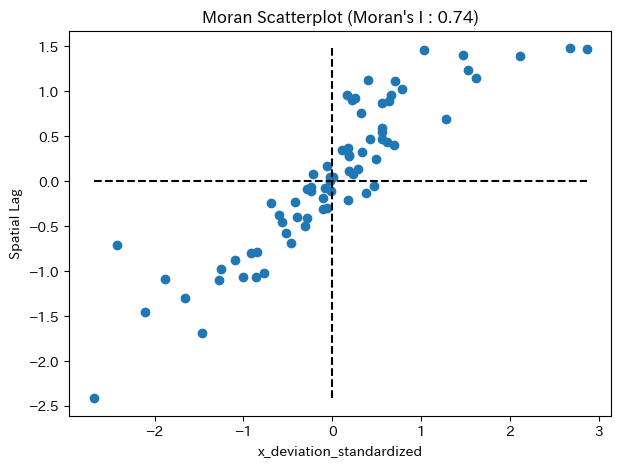

In [32]:
# Moran Scatterplot
# figureとaxを生成
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

xmin, xmax = np.min(z), np.max(z)  # 描画範囲(横軸)の範囲
ymin, ymax = np.min(sl), np.max(sl)  # 描画範囲(縦軸)の範囲

ax = plt.scatter(z, sl)  # 散布図
ax = plt.hlines(0, xmin, xmax, 'black', 'dashed')  # 横軸
ax = plt.vlines(0, ymin, ymax, 'black', 'dashed')  # 縦軸

plt.title(f"Moran Scatterplot (Moran's I : {np.round(GMI, 2)})")  # 題名
plt.xlabel('x_deviation_standardized')  # 横軸のラベル
plt.ylabel('Spatial Lag')  # 縦軸のラベル
# 図の保存
fig.savefig("./Chapter2/figures/figure2_3.png")
# 図の表示
plt.show()

###2.3.5 モジュールを利用してGlobal Moran's Iを求める

In [33]:
# 行和で基準化
wr.transform = "R"
# moran's Iのオブジェクトを作成
#引数に対象データとweightsで作成したwrオブジェクトが必要
moran = esda.moran.Moran(gdf_osaka["log_price"], wr)

In [34]:
print('moran_I : ', moran.I)
print('p_sim : ', moran.p_sim)
print('z_sim : ', moran.z_sim)
print('p_z_sim : ', moran.p_z_sim)

moran_I :  0.744821273246302
p_sim :  0.001
z_sim :  9.47807907721407
p_z_sim :  1.2950348597853885e-21


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


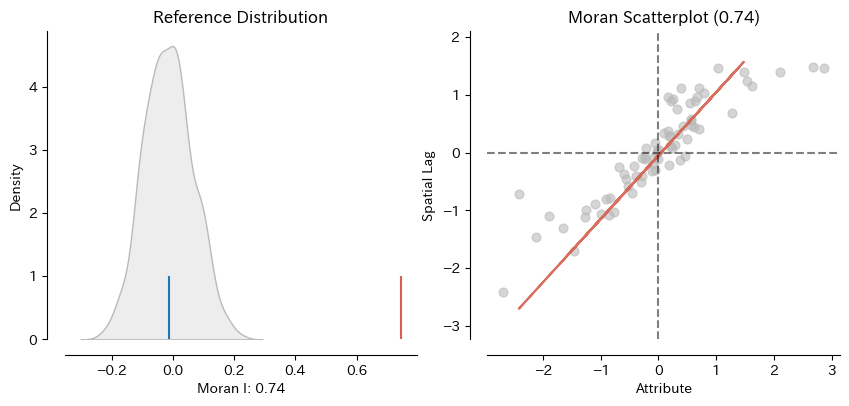

In [35]:
# 描画
plot_moran(moran);

## 2.4 空間的自己相関(2)～Local Moran's I

###2.4.1 Local Moran's Iとは

In [36]:
# Local Moran's Iを求める
def culc_LMI(x,swm):
  x_bar = np.mean(x)
  x_dev = x - x_bar  # 偏差のベクトルを求める
  N = len(x)  # データ数はN

  LMI = []

  for i in range(N):
    LMI_i = (x[i] - x_bar) * (swm[i,:] @ x_dev) / (x_dev @ x_dev / (N-1))
    LMI.append(LMI_i)

  return LMI

In [37]:
LMI = culc_LMI(x, swm)
LMI

[1.4938948833893364,
 1.864888804201492,
 0.4394379761401526,
 2.899882809256982,
 0.5615159778073355,
 0.1614962982910268,
 1.829616449350055,
 2.039416932344982,
 0.19645469813590466,
 0.47294911468712614,
 0.7726263264148847,
 0.23763809123089766,
 0.3252248100757121,
 0.6279324561997727,
 0.8678155610237767,
 0.2796778091289595,
 0.2592021245554809,
 0.23288301699814806,
 0.7984475305138726,
 0.11829649502353672,
 0.10614019059891415,
 0.03849206800852208,
 3.908166267847437,
 4.145515395199704,
 0.06256658288003969,
 0.0161314405110303,
 0.01869643284932916,
 0.0014713193090558762,
 0.15474114908257577,
 -0.025785100680608714,
 0.16358643182986074,
 0.31651242495185156,
 0.30455350652407054,
 0.19503040524465706,
 0.2682716906819164,
 0.11562015534422043,
 0.02066965315676453,
 0.7231022921630548,
 0.054195454182132397,
 -0.0012700739709183976,
 -0.035869146559120976,
 0.005577106060626108,
 0.9021488683390577,
 0.7719094031986353,
 8.054981621719434e-05,
 0.6569852084143606,
 -0.

In [38]:
lisa = esda.moran.Moran_Local(gdf_osaka["log_price"], wr)

In [39]:
lisa.Is

array([ 1.49389488e+00,  1.86488880e+00,  4.39437976e-01,  2.89988281e+00,
        5.61515978e-01,  1.61496298e-01,  1.82961645e+00,  2.03941693e+00,
        1.96454698e-01,  4.72949115e-01,  7.72626326e-01,  2.37638091e-01,
        3.25224810e-01,  6.27932456e-01,  8.67815561e-01,  2.79677809e-01,
        2.59202125e-01,  2.32883017e-01,  7.98447531e-01,  1.18296495e-01,
        1.06140191e-01,  3.84920680e-02,  3.90816627e+00,  4.14551540e+00,
        6.25665829e-02,  1.61314405e-02,  1.86964328e-02,  1.47131931e-03,
        1.54741149e-01, -2.57851007e-02,  1.63586432e-01,  3.16512425e-01,
        3.04553507e-01,  1.95030405e-01,  2.68271691e-01,  1.15620155e-01,
        2.06696532e-02,  7.23102292e-01,  5.41954542e-02, -1.27007397e-03,
       -3.58691466e-02,  5.57710606e-03,  9.02148868e-01,  7.71909403e-01,
        8.05498162e-05,  6.56985208e-01, -1.65758284e-02,  2.93031086e-04,
        2.21436576e-01, -4.77062424e-02,  9.91239284e-02,  2.99009450e-01,
       -9.14788247e-03,  

In [40]:
lisa.p_sim

array([0.002, 0.003, 0.012, 0.001, 0.054, 0.013, 0.001, 0.001, 0.05 ,
       0.013, 0.006, 0.025, 0.095, 0.01 , 0.045, 0.123, 0.145, 0.011,
       0.008, 0.253, 0.234, 0.357, 0.001, 0.001, 0.21 , 0.448, 0.363,
       0.405, 0.177, 0.459, 0.285, 0.124, 0.126, 0.203, 0.123, 0.235,
       0.38 , 0.075, 0.229, 0.461, 0.334, 0.45 , 0.02 , 0.001, 0.497,
       0.031, 0.391, 0.437, 0.147, 0.389, 0.32 , 0.078, 0.354, 0.232,
       0.295, 0.267, 0.165, 0.029, 0.432, 0.414, 0.119, 0.01 , 0.448,
       0.089, 0.015, 0.217, 0.106, 0.073, 0.064, 0.048, 0.017, 0.032])

In [41]:
gdf_osaka['Is'] = lisa.Is
gdf_osaka['p_sim'] = lisa.p_sim

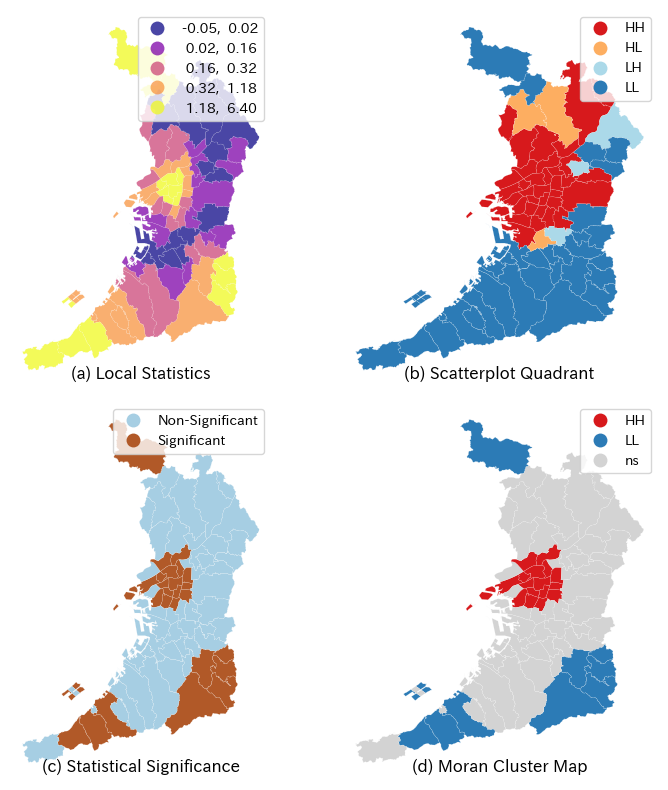

In [42]:
# figureとax(es)を生成
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# 図a(左上)
# z値の分布図
ax = axes[0, 0]
# geopandasデータフレームに各区域のz値に関する新しい列を追加(assignメソッド)し、
# コロプレス図を作成
gdf_osaka.assign(Is=lisa.Is).plot(ax=ax,
                                  column="Is",
                                  cmap="plasma",
                                  scheme="quantiles",
                                  k=5,
                                  edgecolor="white",
                                  linewidth=0.1,
                                  alpha=0.75,
                                  legend=True
                                  )

# 図b(右上)
# Moran Scatterplotの4象限での分類
ax = axes[0, 1]
esdaplot.lisa_cluster(lisa, gdf_osaka, p=1, ax=ax)

# 図c(左下)
# z値が5%有意の地域の分布
ax = axes[1, 0]
# 5%有意ならば1、そうでないなら0のラベルを振る
labels = pd.Series(1 * (lisa.p_sim < 0.05),  # 5%有意なら1、そうでないなら0
                   index=gdf_osaka.index  # 元のデータのインデックスを用いる
                   ).map({1: "Significant", 0: "Non-Significant"})
# geopandasデータフレームに作成したラベルに関する新しい列を追加(assignメソッド)し、
# コロプレス図を作成
gdf_osaka.assign(cl=labels).plot(ax=ax,
                                 column="cl",
                                 categorical=True,
                                 k=2,
                                 cmap="Paired",
                                 linewidth=0.1,
                                 edgecolor="white",
                                 legend=True
                                 )

# 図d(右下)
# クラスターマップ
ax = axes[1, 1]
# 5％有意な地域のみMoran Scatterplotの4象限分類の色で示す
esdaplot.lisa_cluster(lisa, gdf_osaka, p=0.05, ax=ax)

# 図の調整
# 各図のタイトルをつける
for i, ax in enumerate(axes.flatten()):
  ax.set_axis_off()
  ax.set_title(
    [
        "(a) Local Statistics",
        "(b) Scatterplot Quadrant",
        "(c) Statistical Significance",
        "(d) Moran Cluster Map",
     ][i],
     y=0,
  )
# 各図を詰めて表示
fig.tight_layout()
# 図の保存
fig.savefig("./Chapter2/figures/figure2_4.png")
# 図の表示
plt.show()